# Side NoteBook testing Simple MLA for classification using TinyBERT as encoder

### Note for markers: the notebook has the outputs inline but the dataset used for Top5 retreival must be updated according to retrieval model used

# 1.DataSet Processing

### Importing libraries and folder check

In [ ]:
# core
import os, json, pickle, random
from pathlib import Path
from datetime import datetime
import numpy as np

# torch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

# transformers
from transformers import AutoTokenizer, get_linear_schedule_with_warmup
from transformers import AutoModel, AutoConfig

# sklearn & logging
from sklearn.metrics import f1_score, accuracy_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt

# reproducibility
SEED = 42
random.seed(SEED); torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{datetime.now()} ▶ CUDA available? {torch.cuda.is_available()}")

2025-05-20 17:22:09.122050 ▶ CUDA available? True


In [ ]:
print("CUDA available →", torch.cuda.is_available())

CUDA available → True


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! ls #drive/MyDrive/COMP90042_2025-main


drive  sample_data


In [ ]:
Project_folder = 'drive/MyDrive/COMP90042_2025-main'
os.chdir(Project_folder)

## DataSet Processing

In [ ]:
DATA, SAVES = Path("data"), Path("saves")


def build_sentence_masks(text, tok, max_len, max_sent):
    sents = text.split(". ")[:max_sent]
    enc   = tok(text, truncation=True, max_length=max_len,
                return_offsets_mapping=True, add_special_tokens=False)
    mask = np.zeros((max_sent, max_len), dtype=bool)
    char = 0
    for si, s in enumerate(sents):
        a, b = char, char + len(s)
        for ti, (L, R) in enumerate(enc["offset_mapping"]):
            if ti >= max_len: break
            if L >= a and R <= b:
                mask[si, ti] = True
        char = b + 2
    return mask

def strip_scores(top5_raw):
    return {cid: [triple[0] for triple in triples]
            for cid, triples in top5_raw.items()}


class ClaimEvidenceDataset(Dataset):
    def __init__(self, claim_dict, top5_dict, evid_dict, tok,
                 mode="gold", k_ret=2,
                 max_len=512, max_claim_sent=1, max_evid_sent=5,
                 label_map=None):
        self.data = []
        for cid, meta in claim_dict.items():
            claim = meta["claim_text"]
            gold  = meta.get("evidences", [])
            ret   = top5_dict.get(cid, [])
            if   mode=="gold":      evid_ids = gold
            elif mode=="retrieved": evid_ids = ret
            elif mode=="hybrid":    evid_ids = list(dict.fromkeys(gold + ret[:k_ret]))
            else: raise ValueError(mode)

            evid_txt = " ".join(evid_dict[e] for e in evid_ids)
            enc = tok.encode_plus(
                claim, evid_txt,
                truncation=True, max_length=max_len,
                padding="max_length"
            )
            item = {k: torch.tensor(v) for k,v in enc.items()}
            item["sent_mask_claim"] = torch.tensor(
                build_sentence_masks(claim, tok, max_len, max_claim_sent))
            item["sent_mask_evid"]  = torch.tensor(
                build_sentence_masks(evid_txt, tok, max_len, max_evid_sent))
            item["claim_id"] = cid
            if label_map and "claim_label" in meta:
                item["labels"] = torch.tensor(label_map[meta["claim_label"]])
            self.data.append(item)

    def __len__(self):
        return len(self.data)
    def __getitem__(self, i):
        return self.data[i]


evidence_dict = json.load(open(DATA/"evidence.json"))
train_claims  = json.load(open(DATA/"train-claims.json"))
dev_claims    = json.load(open(DATA/"dev-claims.json"))
test_claims   = json.load(open(DATA/"test-claims-unlabelled.json"))

# # train/test JSON → strip scores
# train_top5 = strip_scores(json.load(open(SAVES/"train_top5_distilbert.json")))
# test_top5  = strip_scores(json.load(open(SAVES/"test_top5_distilbert.json")))

# # dev from pickle ## Note to markers: uncomment when file is known!
# with open(SAVES/"distilbert_pairwise_001-Top5.pkl","rb") as f:
#     dev_top5 = pickle.load(f)
# with open(SAVES/"train_distilbert_pairwise_001-Top5.pkl","rb") as f:
#     train_top5 = pickle.load(f)
# with open(SAVES/"test_distilbert_pairwise_001-Top5.pkl","rb") as f:
#     test_top5 = pickle.load(f)
# LABEL2ID = {
#     "SUPPORTS":        0,
#     "REFUTES":         1,
#     "NOT_ENOUGH_INFO": 2,
#     "DISPUTED":        3,
# }
# ID2LABEL = {v:k for k,v in LABEL2ID.items()}


# 2. Model implementation

In [ ]:
class SimpleMLA(nn.Module):
    def __init__(self, hidden, num_layers):
        super().__init__()
        self.L       = num_layers
        self.tok_att = nn.Linear(hidden, 1)
        self.layer_w = nn.Parameter(torch.zeros(num_layers))
        self.temp    = nn.Parameter(torch.ones(1))

    def forward(self, hidden_states, mask):
        # hidden_states: list of [B,T,H]; mask: [B,T] bool
        stack = torch.stack(hidden_states[-self.L:], dim=1)  # [B,L,T,H]
        w     = torch.softmax(self.temp * self.layer_w, dim=0)  # [L]
        h     = (w[None,:,None,None] * stack).sum(1)           # [B,T,H]
        att   = self.tok_att(h).squeeze(-1).masked_fill(~mask, -1e4)
        w_tok = torch.softmax(att, dim=-1).unsqueeze(-1)        # [B,T,1]
        return (w_tok * h).sum(1)                               # [B,H]

class TinyBERT_MLA(nn.Module):
    def __init__(self, model_name, num_labels, num_layers=4):
        super().__init__()
        self.bert    = AutoModel.from_pretrained(model_name, output_hidden_states=True)
        H            = self.bert.config.hidden_size
        self.mla_c   = SimpleMLA(H, num_layers)
        self.mla_e   = SimpleMLA(H, num_layers)
        self.cross   = nn.MultiheadAttention(H, num_heads=4, batch_first=True)
        self.classifier = nn.Sequential(
            nn.Linear(2*H, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_labels)
        )

    def forward(self, input_ids, attention_mask, token_type_ids,
                sent_mask_claim, sent_mask_evid):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            output_hidden_states=True
        )
        hs   = outputs.hidden_states       # list of [B,T,H]
        mask = attention_mask.bool()       # [B,T]

        cvec = self.mla_c(hs, (token_type_ids==0)&mask)  # [B,H]
        evec = self.mla_e(hs, (token_type_ids==1)&mask)  # [B,H]

        pair  = torch.stack([cvec, evec], dim=1)         # [B,2,H]
        fused, _ = self.cross(pair, pair, pair)         # [B,2,H]
        feat   = fused.reshape(fused.size(0), -1)        # [B,2H]
        return self.classifier(feat)                     # [B,num_labels]


# 3.Testing and Evaluation

Epoch 1 | train_loss=1.1532 | dev_acc=31.82% | dev_f1=18.65%
Epoch 2 | train_loss=0.9794 | dev_acc=38.96% | dev_f1=24.29%
Epoch 3 | train_loss=0.9633 | dev_acc=49.35% | dev_f1=29.95%
Epoch 4 | train_loss=0.8206 | dev_acc=48.70% | dev_f1=32.82%
Epoch 5 | train_loss=0.7114 | dev_acc=48.05% | dev_f1=31.66%
Saved training_metrics.csv


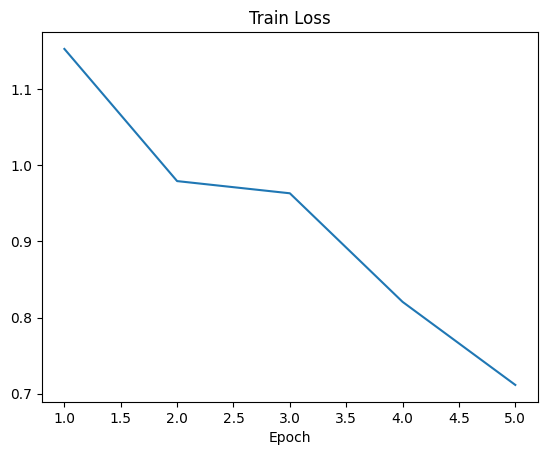

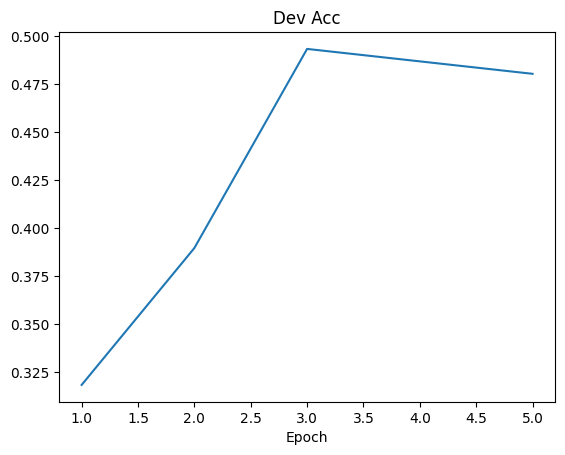

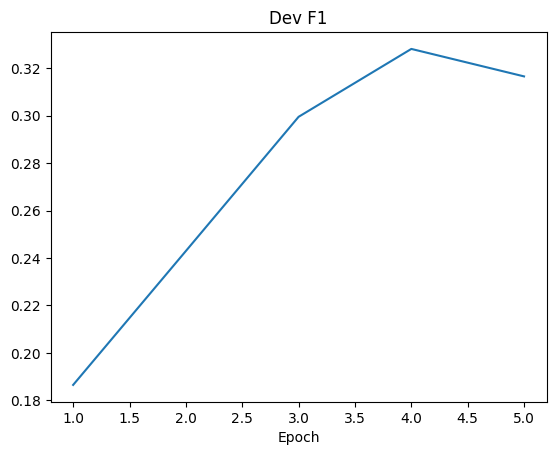


Final Dev Classification Report:

                 precision    recall  f1-score   support

       SUPPORTS      0.514     0.824     0.633        68
        REFUTES      0.409     0.333     0.367        27
NOT_ENOUGH_INFO      0.435     0.244     0.312        41
       DISPUTED      0.000     0.000     0.000        18

       accuracy                          0.487       154
      macro avg      0.339     0.350     0.328       154
   weighted avg      0.414     0.487     0.427       154



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from transformers import AutoTokenizer
tok = AutoTokenizer.from_pretrained("huawei-noah/TinyBERT_General_6L_768D")
# Hyperparams
MAX_EPOCHS = 5   # 2 gold, 3 hybrid
PATIENCE   = 1
BATCH_SIZE = 16

# Prepare lists
epochs_list, train_loss_list = [], []
dev_acc_list, dev_f1_list     = [], []

# Instantiate model, tokenizer, optimizer, criterion
DEVICE    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = TinyBERT_MLA("huawei-noah/TinyBERT_General_6L_768D",
                         num_labels=len(LABEL2ID)).to(DEVICE)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

def get_loader(split, epoch=None):
    if split=="train":
        mode, k = ("gold",0) if epoch<=2 else ("hybrid",2)
        ds = ClaimEvidenceDataset(
            train_claims, train_top5, evidence_dict, tok,
            mode=mode, k_ret=k,
            max_claim_sent=1, max_evid_sent=5,
            label_map=LABEL2ID
        )
        return DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)
    else:
        dct = dev_claims if split=="dev" else test_claims
        t5  = dev_top5   if split=="dev" else test_top5
        ds = ClaimEvidenceDataset(
            dct, t5, evidence_dict, tok,
            mode="retrieved",
            max_claim_sent=1, max_evid_sent=5,
            label_map=LABEL2ID if split=="dev" else None
        )
        return DataLoader(ds, batch_size=32)

from transformers import get_linear_schedule_with_warmup

# Training + Eval loop
best_f1, wait = 0.0, 0
for ep in range(1, MAX_EPOCHS+1):
    # rebuild train loader + scheduler
    train_dl = get_loader("train", ep)
    steps     = len(train_dl)
    sched     = get_linear_schedule_with_warmup(optimizer, int(0.1*steps), steps)

    model.train()
    epochs_list.append(ep)
    total_loss, n = 0.0, 0
    for b in train_dl:
        args   = [b[k].to(DEVICE) for k in
                  ["input_ids","attention_mask","token_type_ids",
                   "sent_mask_claim","sent_mask_evid"]]
        labels = b["labels"].to(DEVICE)
        logits = model(*args)
        loss   = criterion(logits, labels)
        loss.backward()
        optimizer.step(); sched.step(); optimizer.zero_grad()

        total_loss += loss.item()*labels.size(0)
        n += labels.size(0)
    train_loss = total_loss/n
    train_loss_list.append(train_loss)

    # dev eval
    dev_dl = get_loader("dev")
    model.eval()
    y_t, y_p = [], []
    with torch.no_grad():
        for b in dev_dl:
            args   = [b[k].to(DEVICE) for k in
                      ["input_ids","attention_mask","token_type_ids",
                       "sent_mask_claim","sent_mask_evid"]]
            labels = b["labels"].to(DEVICE)
            logits = model(*args)
            preds  = logits.argmax(1)
            y_t.extend(labels.cpu().tolist())
            y_p.extend(preds.cpu().tolist())
    dev_acc = accuracy_score(y_t, y_p)
    dev_f1  = f1_score(y_t, y_p, average="macro")
    dev_acc_list.append(dev_acc)
    dev_f1_list.append(dev_f1)

    print(f"Epoch {ep} | train_loss={train_loss:.4f} | dev_acc={dev_acc:.2%} | dev_f1={dev_f1:.2%}")
    if dev_f1 > best_f1:
        best_f1, wait = dev_f1, 0
        torch.save(model.state_dict(), SAVES/"tinybert_mla_best.pt")
    else:
        wait += 1
        if wait > PATIENCE:
            print("Early stopping.")
            break

# Save metrics + plots
df = pd.DataFrame({
    "epoch": epochs_list,
    "train_loss": train_loss_list,
    "dev_accuracy": dev_acc_list,
    "dev_macro_f1": dev_f1_list
})
df.to_csv("training_metrics.csv", index=False)
print("Saved training_metrics.csv")

plt.figure(); plt.plot(epochs_list, train_loss_list);  plt.title("Train Loss"); plt.xlabel("Epoch"); plt.show()
plt.figure(); plt.plot(epochs_list, dev_acc_list);     plt.title("Dev Acc");   plt.xlabel("Epoch"); plt.show()
plt.figure(); plt.plot(epochs_list, dev_f1_list);      plt.title("Dev F1");    plt.xlabel("Epoch"); plt.show()

# Final dev report
model.load_state_dict(torch.load(SAVES/"tinybert_mla_best.pt", map_location=DEVICE))
y_t, y_p = [], []
with torch.no_grad():
    for b in get_loader("dev"):
        args  = [b[k].to(DEVICE) for k in
                 ["input_ids","attention_mask","token_type_ids",
                  "sent_mask_claim","sent_mask_evid"]]
        logits= model(*args)
        preds = logits.argmax(1).cpu().tolist()
        y_p.extend(preds)
        y_t.extend(b["labels"].tolist())

print("\nFinal Dev Classification Report:\n")
print(classification_report(y_t, y_p,
      target_names=[l for l,_ in sorted(LABEL2ID.items(), key=lambda x:x[1])],
      digits=3))


In [ ]:
# print("Logs & metrics saved:")
# print(" ", SAVES/"tinybert_mla_best.pt")
# print(" ", "training_metrics.csv")

Logs & metrics saved:
  saves/tinybert_mla_best.pt
  training_metrics.csv
